###Nama      : Aprillia Nur Azizah 
###Unsername : aprillianuraz
###Email     : aprilliaazizah3@gmail.com

In [193]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [194]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn import preprocessing

In [195]:
df = pd.read_csv('/content/drive/MyDrive/Dicoding/Dataset/DailyDelhiClimate.csv', parse_dates=['date'], index_col='date')
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [197]:
#Cek Missing Value
df.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [198]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month
df.head()

,meantemp,humidity,wind_speed,meanpressure,hour,day_of_week,day_of_month,month
date,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,0,1,1,1
2013-01-02,7.400000,92.000000,2.980000,1017.800000,0,2,2,1
2013-01-03,7.166667,87.000000,4.633333,1018.666667,0,3,3,1
2013-01-04,8.666667,71.333333,1.233333,1017.166667,0,4,4,1
2013-01-05,6.000000,86.833333,3.700000,1016.500000,0,5,5,1


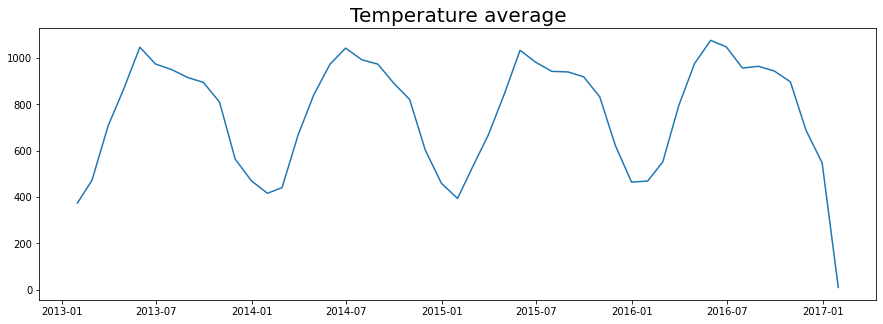

In [199]:
#Grafik meantemp setiap bulan 
data_by_month = df.resample('M').sum()
time = data_by_month.index.values
temp = data_by_month['meantemp'].values
plt.figure(figsize=(15,5))
plt.plot(time, temp)
plt.title('Temperature average',
          fontsize=20);

In [200]:
train_size = int(len(df) * 0.8) # train dataset 80%
train, val = df.iloc[0:train_size], df.iloc[train_size:len(df)]#validation 20%

print(train.shape, val.shape)

(1169, 8) (293, 8)


In [201]:
#normalization 
transformer = RobustScaler()
temp_transformer = transformer.fit(train[['meantemp']])
train['meantemp'] = temp_transformer.transform(train[['meantemp']])
val['meantemp'] = temp_transformer.transform(val[['meantemp']])

scaler = preprocessing.MinMaxScaler()
temp_scaler = scaler.fit(train[['meantemp']])
train['meantemp'] = temp_scaler.transform(train[['meantemp']])
val['meantemp'] = temp_scaler.transform(val[['meantemp']])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [202]:
scale_col = ['humidity', 'wind_speed', 'meanpressure']
scale_transformer = transformer.fit(train[scale_col].to_numpy())
train.loc[:, scale_col] = scale_transformer.transform(
    train[scale_col].to_numpy()
)

val.loc[:, scale_col] = scale_transformer.transform(
    val[scale_col].to_numpy()
)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [203]:
steps = 20
def createDataset(X, y, steps):
    Xs, ys = [], []
    for i in range(len(X) - steps):
        data = X.iloc[i:(i + steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + steps])
        
    return np.array(Xs), np.array(ys)

x_train, y_train = createDataset(train, train.meantemp, steps)
x_val, y_val = createDataset(val, val.meantemp, steps)
print(x_train.shape, y_train.shape)

(1149, 20, 8) (1149,)


In [204]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [205]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [206]:
class my_allback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') < 0.1):
            print("MAE < 10%")
            self.model.stop_training = True

    def on_train_end(self, epoch, logs={}):
        print('Done')

callbacks = my_allback()

In [208]:
history = model.fit(x_train,
                    y_train,
                    epochs=100,
                    steps_per_epoch = 50,
                    batch_size=32,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks = callbacks)

Epoch 1/100
50/50 [==============================] - 2s 31ms/step - loss: 0.0180 - mae: 0.1581 - val_loss: 0.0152 - val_mae: 0.1476
Epoch 2/100
50/50 [==============================] - 2s 31ms/step - loss: 0.0183 - mae: 0.1615 - val_loss: 0.0142 - val_mae: 0.1424
Epoch 3/100
50/50 [==============================] - 2s 31ms/step - loss: 0.0163 - mae: 0.1501 - val_loss: 0.0131 - val_mae: 0.1370
Epoch 4/100
50/50 [==============================] - 2s 31ms/step - loss: 0.0152 - mae: 0.1455 - val_loss: 0.0123 - val_mae: 0.1321
Epoch 5/100
50/50 [==============================] - 2s 31ms/step - loss: 0.0141 - mae: 0.1400 - val_loss: 0.0114 - val_mae: 0.1266
Epoch 6/100
50/50 [==============================] - 2s 31ms/step - loss: 0.0129 - mae: 0.1328 - val_loss: 0.0107 - val_mae: 0.1214
Epoch 7/100
50/50 [==============================] - 2s 31ms/step - loss: 0.0129 - mae: 0.1336 - val_loss: 0.0098 - val_mae: 0.1158
Epoch 8/100
50/50 [==============================] - 2s 31ms/step - loss: 0.

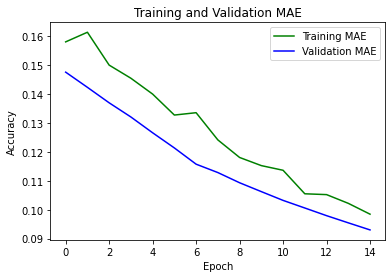

In [209]:
#MAE Plot
accry = history.history['mae']
validation_accry = history.history['val_mae']
plt.plot(accry, 'g', label='Training MAE')
plt.plot(validation_accry , 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

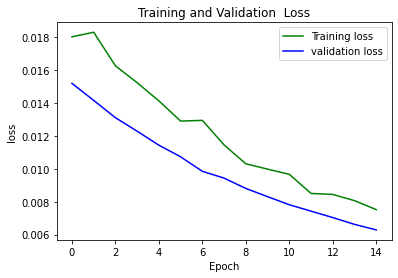

In [210]:
#Loss Plot
loss = history.history['loss']
validation_loss = history.history['val_loss']
plt.plot(loss, 'g', label='Training loss')
plt.plot(validation_loss , 'b', label='validation loss')
plt.title('Training and Validation  Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()